# Regression analysis
In this section, we try to quantify the linear relationship between various covariates and the success metric of choice. By success metric, we mean box office / IMDb ratings / number of oscars / revenue / metacritic rating.

## Dataset incompleteness
In this subsection we plot the dataset's incompleteness. The main problems with our dataset, which are consistent among other analyses we are doing as well is that there are some values missing and it is different ones for each of the success metrics.

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import sys
import matplotlib.pyplot as plt
sys.path.append('../utils')
from tropes_utils import plot_missing_data
from regression_analysis_helpers import one_hot_encode, one_hot_encode_month, frequency_encode, target_encode, format_release_date

### Merge all dataframes into one

In [2]:
movies = pd.read_pickle('../../pickles/cmu_imdb_tmdb_wikidata_merged.pkl')
metacritic = pd.read_pickle('../../pickles/metacritic_df.pkl')
imdb = pd.read_pickle('../../pickles/imdb_data.pkl')
# movie_scores = pd.read_pickle('../../pickles/movie_scores.pkl')

/Users/adamborgula/.pyenv/versions/3.12.7/envs/epfl-ai/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


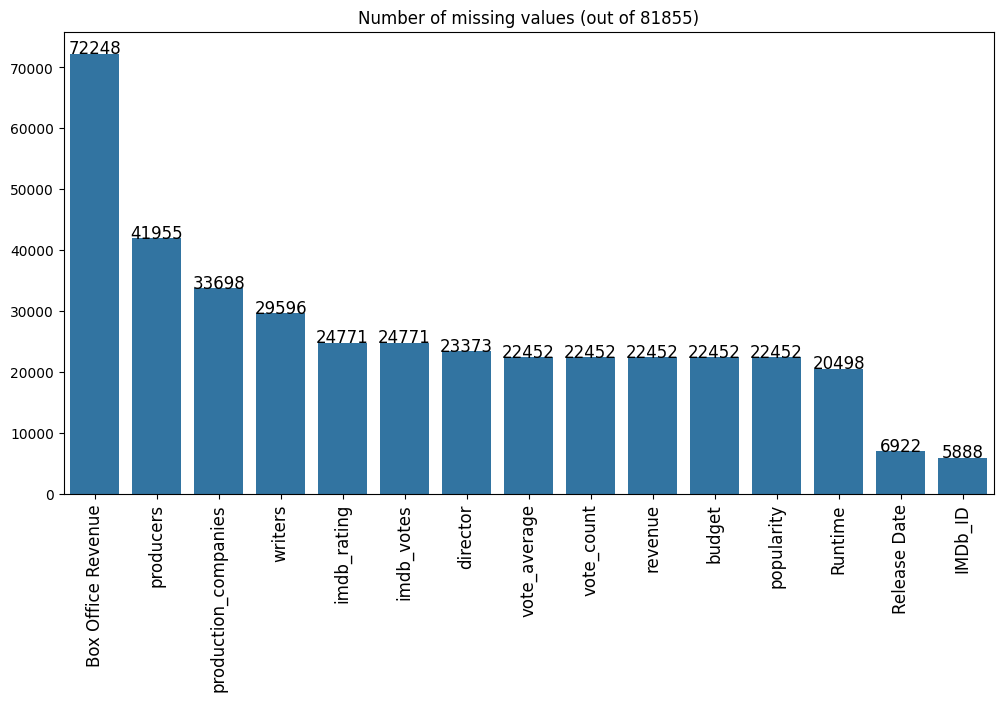

In [3]:
plot_missing_data(movies)

Let's more closely examine the covariates **producers, production_companies, writers, imdb_rating, imdb_votes, director, vote_average, vote_count, revenue, budget and popularity**

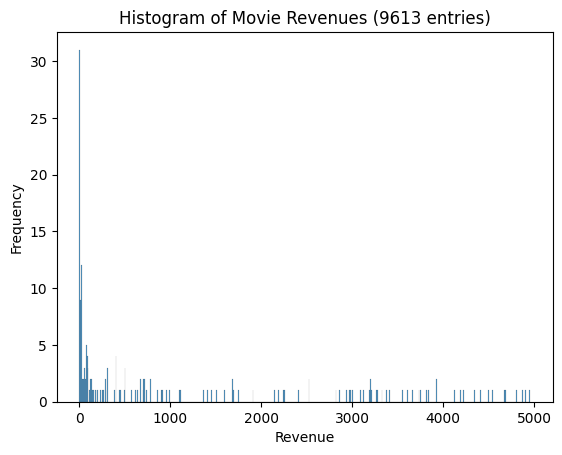

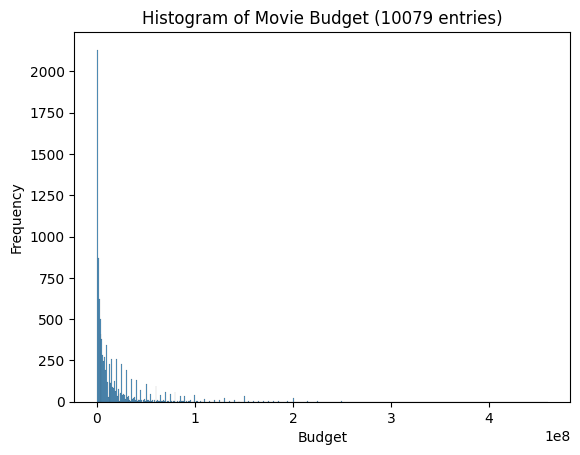

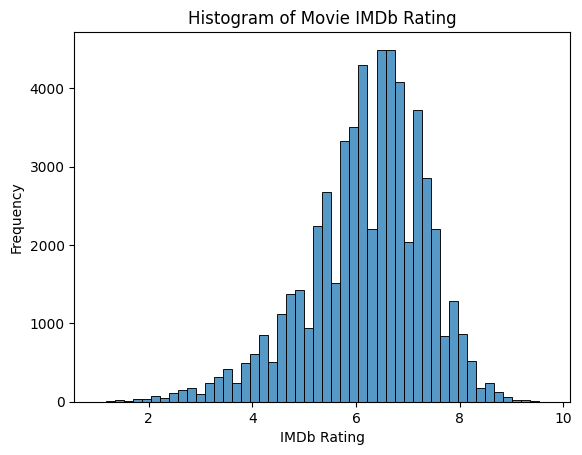

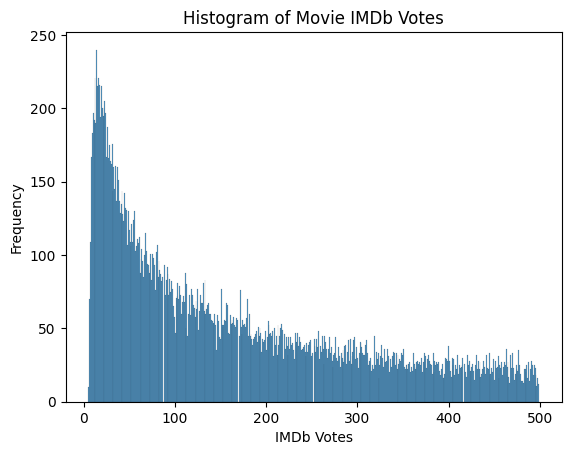

In [4]:

movies_positive_revenue = movies[movies['revenue'] > 0]
# plt.figure(figsize=(10, 6))
sns.histplot(movies_positive_revenue['revenue'][movies['revenue'] < 5000].dropna(), bins=500, kde=False)
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title(f'Histogram of Movie Revenues ({len(movies_positive_revenue)} entries)')
plt.show()

movies_positive_budget = movies[movies['budget'] > 0]
# plt.figure(figsize=(10, 6))
sns.histplot(movies_positive_budget['budget'].dropna(), bins=500, kde=False)
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.title(f'Histogram of Movie Budget ({len(movies_positive_budget)} entries)')
plt.show()

# plt.figure(figsize=(10, 6))
sns.histplot(movies['imdb_rating'].dropna(), bins=50, kde=False)
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Movie IMDb Rating')
plt.show()

# plt.figure(figsize=(10, 6))
sns.histplot(movies['imdb_votes'][movies['imdb_votes'] < 500].dropna(), bins=500, kde=False)
plt.xlabel('IMDb Votes')
plt.ylabel('Frequency')
plt.title('Histogram of Movie IMDb Votes')
plt.show()

<Axes: xlabel='Box Office Revenue', ylabel='revenue'>

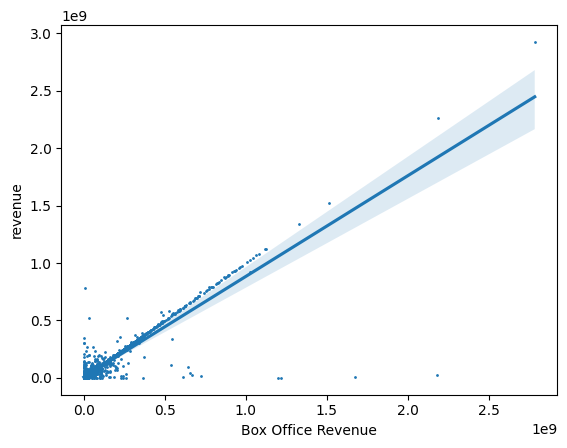

In [5]:
# plot revenue and box office correlation
# keep just columns where we have both values
movies_not_missing = movies[(movies['Box Office Revenue'].notnull()) & (movies['revenue'].notnull())]

# keep just columns where both values are above 0
movies_not_missing = movies_not_missing[movies_not_missing['revenue'] > 0]


plt.scatter(movies_not_missing['Box Office Revenue'], movies_not_missing['revenue'], s=1)

movies_not_missing['Box Office Revenue'] = movies_not_missing['Box Office Revenue'].astype(float)
movies_not_missing['revenue'] = movies_not_missing['revenue'].astype(float)

sns.regplot(x='Box Office Revenue', y='revenue', data=movies_not_missing, scatter=False)

We observed that a lot of revenue data is very low (0 or close to 0). However, for the data points which are bigger, the columns seem to be almost interchangable.

### Observations Conclusion
We can conclude from the above plots, that columns **revenue & budget** are incomplete and should not be used for later analysis.

**IMDb Votes & IMDb Rating** seem to be complete and we will therefore use them in the analysis. The number of votes varies dramatically, but that is to be expected. Ideally, we would want a high number of votes for each movies, but that is not the case. What we could do is only keep movies with the number of votes above certain **threshold**, e.g. 100+ votes. We choose not to do it this way as we want to keep the maximum amount of data related to the ratings.

The other variables which I want to look at are categorical, and therefore, we will encode them later when processing the data.

## Measuring success
We will do regression analysis on **2 success metrics**:
1. IMDb rating
2. box office

These 2 metrics were chosen, because each of them represents a different perspective. IMDb for audience reception and box office represents the profit from the tickets, which directly translates to 

### Covariate selection
We will only use a selection of covariates to make the predictions. Let us start by removing the unnecessary / incomplete ones.

In [ ]:
movies_cleaned = movies

### Encode the categorical variables
We can only use numeric covariates for regression, therefore we encode the non-numeric variables.

In [7]:

movies_encoded = format_release_date(movies_cleaned)
movies_encoded = one_hot_encode_month(movies_encoded)
movies_encoded = frequency_encode(movies_encoded, columns=['production_companies', 'director', 'writers', 'producers']) # tmdb columns

# movies_encoded.info()

The function `format_release_date(df)` extracts year, month and day from the *Release Date* column.

We then choose to do **one hot encoding** for the **month** & **frequency encoding** for the **other categorical variables** (producers, writers, etc.). Frequency encoding takes the total number of occurences of the attributes in particular cell. For example if a movie M is directed by directors d1 & d2, where d1 is a director of 10 movies and d2 director of 20 movies, then the director_frequency_encoding assigned to movie M would be 10 + 20 = 30.

Alternative to frequency encoding is **target encoding**. However, it would directly utilize the target variable, so that would be "cheating" in a sense. Target encoding could be used, if we **split** the data into **train and test** data.

In [8]:
# Unwrap the lists in 'Language Name' column
all_languages = movies_encoded['Language Name'].explode()

# Count the number of unique language names
unique_languages = all_languages.nunique()
print(f'The number of unique language names is: {unique_languages}')

# Unwrap the lists in 'Country Name' column
all_countries = movies_encoded['Country Name'].explode()

# Count the number of unique country names
unique_countries = all_countries.nunique()
print(f'The number of unique country names is: {unique_countries}')

# Unwrap the lists in 'Genre Name' column
all_genres = movies_encoded['Genre Name'].explode()

# Count the number of unique genre names
unique_genres = all_genres.nunique()
print(f'The number of unique genre names is: {unique_genres}')

# print(all_countries.unique()) # TODO print this and debug what is wrong with the names
# print(all_languages.unique())
# print(all_genres.unique())


The number of unique language names is: 207
The number of unique country names is: 147
The number of unique genre names is: 363


Above, the number of distinct languages, countries and genres is too high to use one-hot-encoding. we will therefore use different encoding instead.

In [9]:
# transform language, country & genre to a ', ' separated string instead of a list
movies_encoded['Language Name'] = movies_encoded['Language Name'].apply(lambda x: ', '.join(x))
movies_encoded['Country Name'] = movies_encoded['Country Name'].apply(lambda x: ', '.join(x))
movies_encoded['Genre Name'] = movies_encoded['Genre Name'].apply(lambda x: ', '.join(x))

# # Add a boolean variable is_american & is_uses_english
# movies_encoded['is_american'] = movies_encoded['Country Name'].apply(lambda x: 'United States of America' in x)
# movies_encoded['is_uses_english'] = movies_encoded['Language Name'].apply(lambda x: 'English Language' in x)

# TODO also add a variable for the most interesting genres (to be decided how to pick those)
# Perhaps group the genres into ~20 clusters and then add encoding for the clusters which a movie appears in

movies_encoded = frequency_encode(movies_encoded, columns=['Language Name', 'Country Name', 'Genre Name']) # original columns

We may either frequency encode the language and country or add boolean variables for when the movie uses **English Language** and also when the movie is from **United States of America** since these are the most dominant ones.

When it comes to **genre**, frequency encoding seems to be our best option right now, but performing some form of clustering to reduce the amount of classes, followed by boolean encoding would be an ideal option to keep the most information in the data.

### Prepare dataframe for regression

In [10]:
# Calculate the average runtime
average_runtime = movies_encoded['Runtime'].mean()

# # Replace missing runtime values with the average runtime
# movies_encoded['Runtime'].fillna(average_runtime, inplace=True)

# Drop all rows where runtime is NaN (This is alternative approach to replacing with mean)
movies_encoded.dropna(subset=['Runtime'], inplace=True)

# Drop movies with runtime greater than or equal to runtime_threshold (remove outliers - e.g. TV series)
runtime_threshold = 400
movies_encoded = movies_encoded[movies_encoded['Runtime'] < runtime_threshold]

In [11]:
# Fix the naming to use '_' instead of ' '
movies_encoded.columns = movies_encoded.columns.str.replace(' ', '_')

In [12]:
columns_to_standardize = ['Runtime', 'production_companies_frequency_encoded',
                          'director_frequency_encoded', 'writers_frequency_encoded', 
                          'producers_frequency_encoded', 'Language_Name_frequency_encoded', 
                          'Country_Name_frequency_encoded', 'Genre_Name_frequency_encoded']

# Standardize the specified columns using z-score
movies_encoded[columns_to_standardize] = movies_encoded[columns_to_standardize].apply(zscore)

In [13]:
# Transform all boolean columns to integers
bool_columns = movies_encoded.select_dtypes(include='bool').columns
movies_encoded[bool_columns] = movies_encoded[bool_columns].astype(int)

# Drop unnecessary columns
columns_to_drop = ['director', 'writers', 'producers', 'production_companies', 
                   'Language_Name', 'Country_Name', 'Genre_Name',
                   'Box_Office_Revenue', 'Movie_Name', 'Release_Date',
                   'Release_Month', 'Release_Day', 'IMDb_ID',
                   'vote_average', 'vote_count', 'imdb_rating', 'imdb_votes',
                   'Wikipedia_Movie_ID', 'Freebase_Movie_ID', 
                   'Language_Freebase_ID', 'Country_Freebase_ID', 'Genre_Freebase_ID', 
                   'revenue', 'budget', 'popularity']

features = movies_encoded.drop(columns=columns_to_drop)

### Plot correlation between different covariates

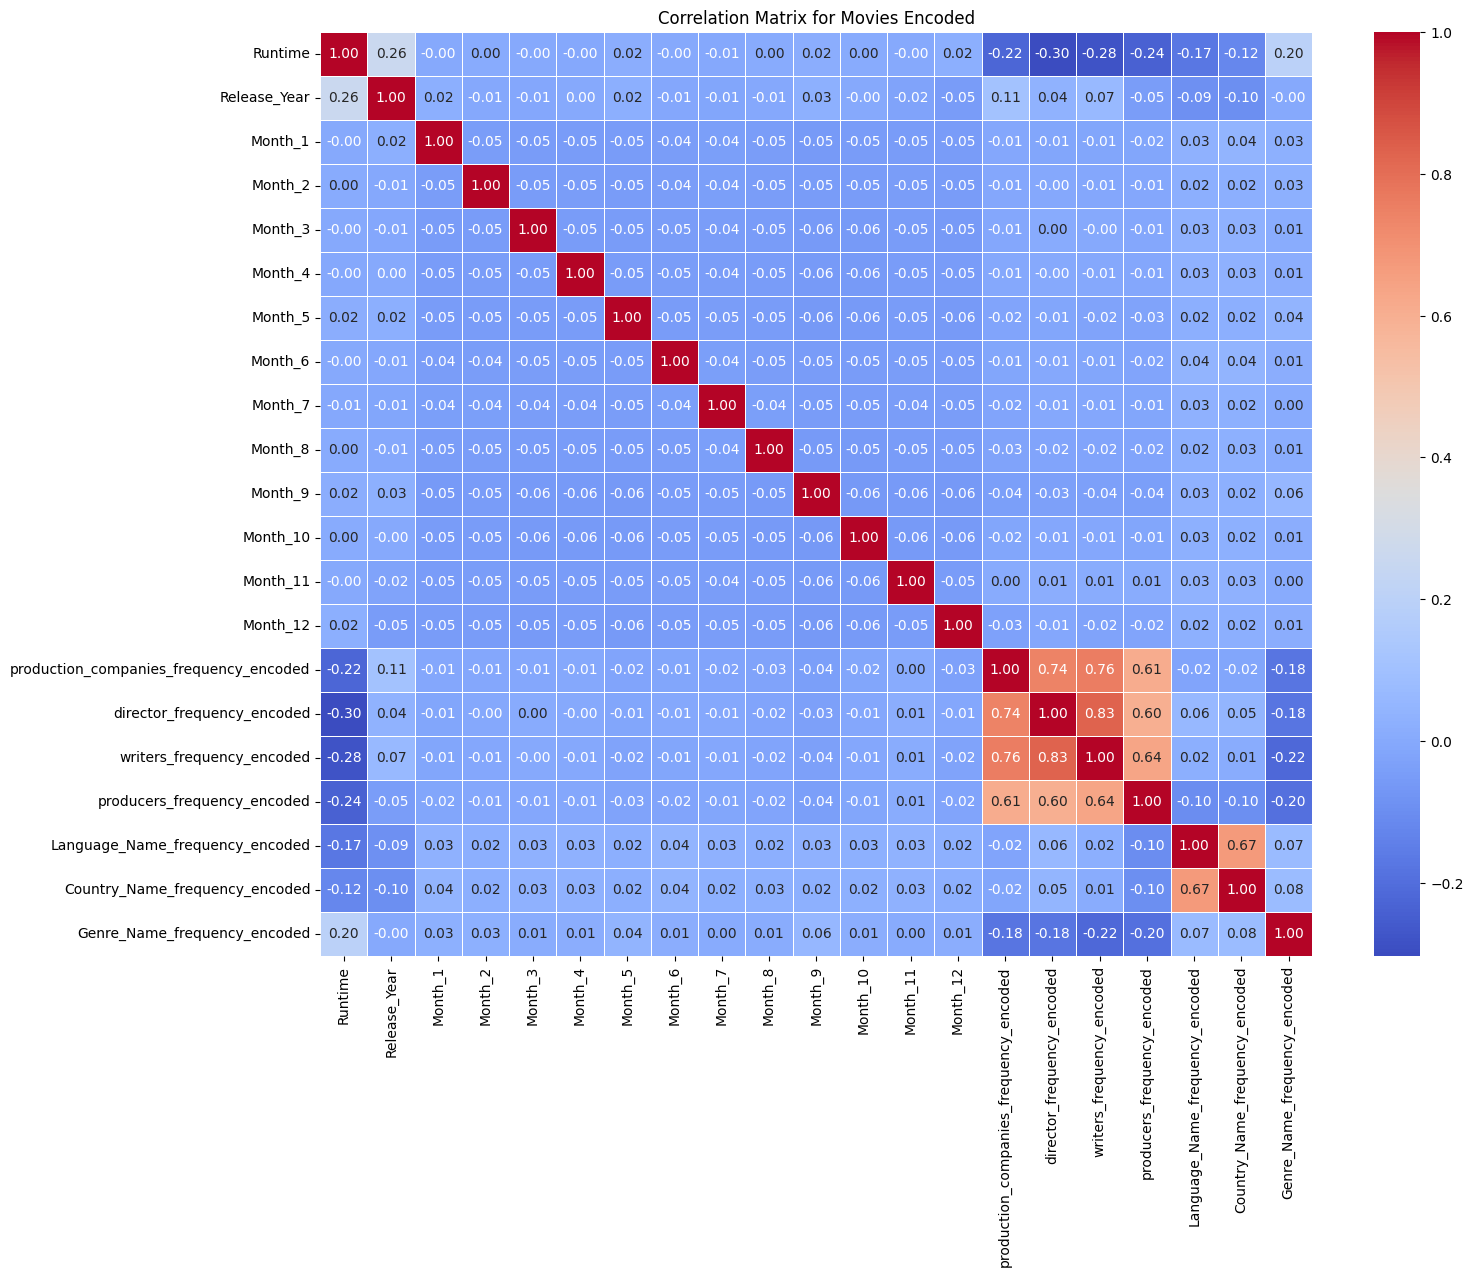

In [14]:
# Compute the correlation matrix
corr_matrix = features.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Movies Encoded')
plt.show()

We can see that there is almost no correlation between our variables, except for 2 clusters.

1. the columns **'director', 'writers', 'producers', 'production_companies'** seem to have high correlation after frequency encoding. this can likely be explained with the fact that famous directors tend to work with famous writers, producers and production companies.

2. The **language & country** show high correlation. This correlation comes naturally from the countries using their appropriate language.

We therefore include only some of these variables. The final choice is a result of some experimentation.

In [15]:
# We drop columns with very high correlation

columns_to_drop = ['writers_frequency_encoded', 'producers_frequency_encoded']
features = features.drop(columns=columns_to_drop)

## Linear Regression

We can finally use our prepared features to fit linear regression model.

In [16]:
features_string = ' + '.join(features.columns)
categorical_columns = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
                       'Month_10', 'Month_11', 'Month_12', 'is_american', 'is_uses_english']

# features_string = ' + '.join([f'C({col})' if col in categorical_columns else col for col in features.columns])
features_string = ' + '.join([col for col in features.columns])
# print(features_string)
print(f'Box Office Revenue ~  {features_string}')
# features.columns

Box Office Revenue ~  Runtime + Release_Year + Month_1 + Month_2 + Month_3 + Month_4 + Month_5 + Month_6 + Month_7 + Month_8 + Month_9 + Month_10 + Month_11 + Month_12 + production_companies_frequency_encoded + director_frequency_encoded + Language_Name_frequency_encoded + Country_Name_frequency_encoded + Genre_Name_frequency_encoded


### Box Office Revenue

Only keep the rows which have all the values

In [17]:
import statsmodels.formula.api as smf

relevant_columns = list(features.columns) + ['Box_Office_Revenue']
box_office_analysis = movies_encoded[relevant_columns]
box_office_analysis = box_office_analysis.dropna()
box_office_analysis['Box_Office_Revenue'] = box_office_analysis['Box_Office_Revenue'].astype(float)

# Standardize the Box Office Revenue using z-score
box_office_analysis['Box_Office_Revenue'] = zscore(box_office_analysis['Box_Office_Revenue'])

mod = smf.ols(formula=f'Box_Office_Revenue ~  {features_string}', data=box_office_analysis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     Box_Office_Revenue   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     49.39
Date:                Fri, 15 Nov 2024   Prob (F-statistic):          2.32e-177
Time:                        20:53:39   Log-Likelihood:                -12444.
No. Observations:                9085   AIC:                         2.493e+04
Df Residuals:                    9065   BIC:                         2.507e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [18]:
box_office_analysis['Runtime'].max()

7.931611477459457

**Months:** We have only ±9400 observations here, so the results are not as robust, but we can see that releasing in month_5, month_6 and month_7 has the highest additive increase, secondly it is month_11 and month_12, which confirms the phenomena about summer & winter booms. They also have low p-values, which means the results are statistically significant. 

This cannot be said about month_8 and month_9. The p-value there is too high to draw any conclusions for these columns. 

**Director & Country frequency:** Further, it seems that diretor_frequency_encoded & country_name_frequency_encoded has a slight additive increase, which means the more movies the director produced, the higher chance of good box office revenue. Similarly, the more movies the countries have produced, the bigger the additive effect.

**Runtime:** Interestingly enough, runtime has an additive influence & low p-value.

### IMDB Rating

In [19]:
relevant_columns = list(features.columns) + ['imdb_rating']
box_office_analysis = movies_encoded[relevant_columns]
box_office_analysis = box_office_analysis.dropna()

# Standardize the IMDb rating using z-score
box_office_analysis['imdb_rating'] = zscore(box_office_analysis['imdb_rating'])

mod = smf.ols(formula=f'imdb_rating ~  {features_string}', data=box_office_analysis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            imdb_rating   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     189.9
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:53:39   Log-Likelihood:                -63649.
No. Observations:               46081   AIC:                         1.273e+05
Df Residuals:                   46061   BIC:                         1.275e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Consistently with the previous results, increasing **runtime** seems to have a positive additive effect on the score.

When it comes to the months, **September**, **December**, May and **January** seem to have the highest coefficients and low p-values. We no longer see the summer-boom effect here. Perhaps this confirms that the summer movies are simple and feel-good, which causes the movies in colder months to rank better?

Frequencies suggest that frequent **directors** as well as **genres** are a positive predictor of a good movie rating.

## Additional for M3

### Predict if score is above a threshold
We can also fit a model to predict whether a score is above a certain threshold

In [20]:
# model to predict if imdb_rating > threshold
threshold_standardized = 8 

relevant_columns = list(features.columns) + ['imdb_rating']
box_office_analysis = movies_encoded[relevant_columns]

box_office_analysis = box_office_analysis.dropna()
box_office_analysis['imdb_rating_above_threshold'] = (box_office_analysis['imdb_rating'] > threshold_standardized).astype(int)

mod = smf.logit(formula=f'imdb_rating_above_threshold ~  {features_string}', data=box_office_analysis)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.106296
         Iterations 9
                                Logit Regression Results                               
Dep. Variable:     imdb_rating_above_threshold   No. Observations:                46081
Model:                                   Logit   Df Residuals:                    46061
Method:                                    MLE   Df Model:                           19
Date:                         Fri, 15 Nov 2024   Pseudo R-squ.:                 0.06453
Time:                                 20:53:39   Log-Likelihood:                -4898.2
converged:                                True   LL-Null:                       -5236.1
Covariance Type:                     nonrobust   LLR p-value:                4.813e-131
                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------